<h1> Setup </h1>


In [1]:
import matplotlib.pyplot as plt
from coffea.nanoevents import NanoEventsFactory, DelphesSchema, NanoAODSchema
import awkward as ak
import dask_awkward as dak
import numpy as np
import uproot
from hist import Hist, axis
import os

#Constants
current_dir = os.getcwd()
tree_name= "Delphes"  #all of them are named delphes
luminescence = 300 #fb

#Signal
signal_crossSection = 0.0018 * 1000 #times 1000 to convert from pb to fb

signal_folder = "Signals_DMSimpl_Spin0/"
signal_filename =  "VBF_DM_My0_1000_MXD_10.root"
signal_filepath = signal_folder +signal_filename
signal_file = uproot.open(signal_folder +signal_filename)


#Background
background_folders = {"BKG_Wjets_WToLNu" : 47744.85 * 1000,
                       "BKG_Zjets_ZToNuNu": 8818.65 * 1000}  #foldername, significance



     #all this is temp for now
#will store data to be used in final "cut chart"
num_cuts = 5
SM_events = [1000,700,200]
NP_events = [500,400,300]
Significance = [1,2.4,5]
   


<h2> Bins </h2>

In [2]:
binning = {
    "PT": {"range": (20, 1000), "bins": 14},  # (300 - 20) / 20 = 14 bins
    "Eta*Eta": {"range": (-25, 25), "bins": 500},  # (25 - (-25)) / 0.1 = 500 bins
    "Delta_Eta": {"range": (0, 10), "bins": 100},  # (10 - 0) / 0.1 = 100 bins
    "Transverse": {"range": (0, 500), "bins": 100},  # (2000 - 500) / 20 = 75 bins
    "Eta": {"range": (-5, 5), "bins": 100},  # (5 - (-5)) / 0.1 = 100 bins
    "Phi": {"range": (-(np.pi), np.pi), "bins": 63},  
    "Invariant": {"range": (50, 3000), "bins": 148}  # (3000 - 50) / 20 = 147.5, rounded to 148 bins
}



<h2> Functions </h2>

<h4>Calculations </h4>

In [3]:
def calculateWeight(num_events, effective_area, lumi):
    return effective_area * lumi / num_events

def calculateSignificance(numSig,numBkg):
    return numSig/np.sqrt(numSig + numBkg)

<h4> Tree / Plotting Functions </h4>

In [4]:
def openTree(tree_filepath):
    #Open tree and only keep stuff that we need
    
    file = uproot.open(tree_filepath)
    tree = file[tree_name]

    #What we want to keep
    branches_wanted = [
        "MissingET.MET",
        "MissingET.Phi",
        "Jet.PT",
        "Jet.Phi",
        "Jet.Eta"
    ]
    df = tree.arrays(branches_wanted,library="pd")

    return df

In [5]:
def getJetsDataNew(dataname): 
    #used when we are working with J0,J1 stuff (which is alot)
    
    #Get Signal Data
    df = openTree(signal_filepath)
    
    # Extract signal jet data
    signal_jets = df["Jet." + dataname].values
    signal_filtered_jets = [entry for entry in signal_jets if len(entry) >= 2]  # At least two entries
    signal_j0 = np.array([entry[0] for entry in signal_filtered_jets])
    signal_j1 = np.array([entry[1] for entry in signal_filtered_jets])

    numSigEvents = len(signal_j0)
    signal_weight = calculateWeight(num_events=numSigEvents, effective_area=signal_crossSection, lumi=luminescence)

    # Background processing
    background_j0_list = []
    background_j1_list = []
    background_weight_list = []

    for folder_name in os.listdir(current_dir):
        folder_path = os.path.join(current_dir, folder_name)

        # Check if the current item is a directory and if its name is in the background_folders dictionary
        if os.path.isdir(folder_path) and folder_name in background_folders:
            cross_section = background_folders[folder_name]

            for root_file in os.listdir(folder_path):
                if root_file.endswith(".root"):
                    file_path = os.path.join(folder_path, root_file)
                    background_df = openTree(file_path)  # Use openTree to get the DataFrame

                    # Extract and filter jet data
                    background_jets = background_df["Jet." + dataname].values
                    background_filtered_jets = [entry for entry in background_jets if len(entry) >= 2]  # At least two entries

                    # Extract J0 and J1
                    background_j0 = np.array([entry[0] for entry in background_filtered_jets])
                    background_j1 = np.array([entry[1] for entry in background_filtered_jets])

                    numBkgEvents = len(background_j0)
                    calculatedWeight = calculateWeight(num_events=numBkgEvents, effective_area=cross_section, lumi=luminescence)

                    background_j0_list.append(background_j0)
                    background_j1_list.append(background_j1)
                    background_weight_list.append(calculatedWeight)

    return signal_j0, signal_j1, signal_weight, background_j0_list, background_j1_list, background_weight_list

In [6]:
def PlotJetsNew(binname,dataname):
    j0_hist_background = Hist(
            axis.Regular(binning[binname]["bins"], *binning[binname]["range"], name="thedata", label=dataname+"J0")
        )
    j0_hist_signal = Hist(
        axis.Regular(binning[binname]["bins"], *binning[binname]["range"], name="thedata", label=dataname+"J0")
    )

    #J1
    j1_hist_background = Hist(
        axis.Regular(binning[binname]["bins"], *binning[binname]["range"], name="thedata", label=dataname+"J1")
    )
    j1_hist_signal = Hist(
        axis.Regular(binning[binname]["bins"], *binning[binname]["range"], name="thedata", label=dataname+"J1")
    )

    j0sig, j1sig, sigweight, bkgj0list, bkgj1list, bkgweightlist = getJetsDataNew(dataname)

    j0_hist_signal.fill(thedata=j0sig, weight=sigweight)
    j1_hist_signal.fill(thedata=j1sig, weight=sigweight)


    for i in range(len(bkgweightlist)):
        j0_hist_background.fill(thedata=bkgj0list[i], weight=bkgweightlist[i])
        j1_hist_background.fill(thedata=bkgj1list[i], weight=bkgweightlist[i])
    

    # Create a figure and a set of subplots (2 columns, 1 row)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot J0
    axs[0].stairs(
        j0_hist_background.values(),
        j0_hist_background.axes[0].edges,
        color='blue',
        label='Background',
        linewidth=2
    )
    axs[0].stairs(
        j0_hist_signal.values(),
        j0_hist_signal.axes[0].edges,
        color='red',
        label='Signal',
        linewidth=3
    )
    axs[0].set_xlabel(dataname+'(j0)')
    axs[0].set_ylabel('Counts')
    axs[0].set_yscale('log')
    axs[0].set_title(dataname+'(j0) Distributions')
    axs[0].legend()
    axs[0].grid(True)

    # Plot J1
    axs[1].stairs(
        j1_hist_background.values(),
        j1_hist_background.axes[0].edges,
        color='blue',
        label='Background',
        linewidth=2
    )
    axs[1].stairs(
        j1_hist_signal.values(),
        j1_hist_signal.axes[0].edges,
        color='red',
        label='Signal',
        linewidth=3
    )
    axs[1].set_xlabel(dataname+'(j1)')
    axs[1].set_ylabel('Counts')
    axs[1].set_yscale('log')
    axs[1].set_title(dataname+'(j1) Distributions')
    axs[1].legend()
    axs[1].grid(True)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

<h1> Plot Everything</h1>

<h3> MET <h3>

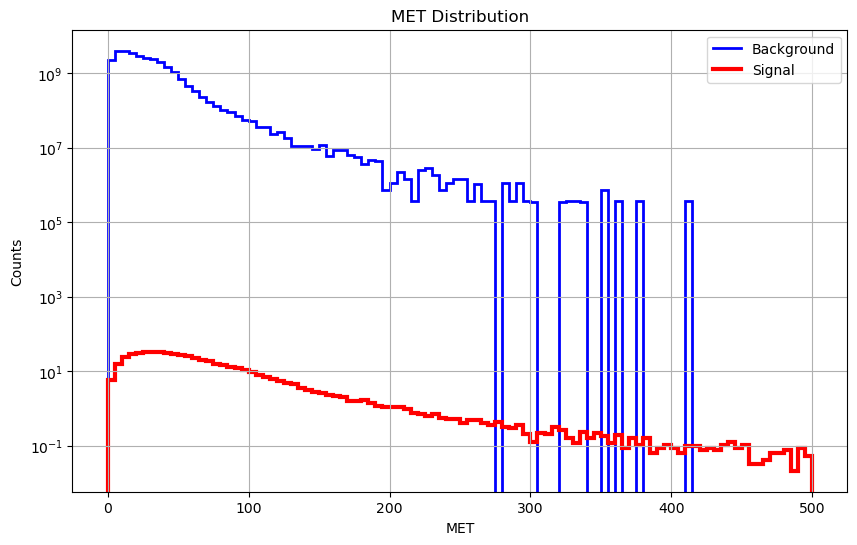

In [7]:
# Create histograms
met_hist_background = Hist(
    axis.Regular(binning["Transverse"]["bins"], *binning["Transverse"]["range"], name="MET", label="MET")
)
met_hist_signal = Hist(
    axis.Regular(binning["Transverse"]["bins"], *binning["Transverse"]["range"], name="MET", label="MET")
)


#Signal Data
signal_tree = signal_file[tree_name]
signal_met = signal_tree["MissingET.MET"].array(library="np")
numSigEvents = len(signal_met)
signal_weight = calculateWeight(num_events=numSigEvents, effective_area= signal_crossSection, lumi = luminescence)

met_hist_signal.fill(MET=signal_met,weight = signal_weight)

#Background
for folder_name in os.listdir(current_dir):
    folder_path = os.path.join(current_dir, folder_name)
        
    # Check if the current item is a directory and if its name is in the background_folders dictionary
    if os.path.isdir(folder_path) and folder_name in background_folders:
        cross_section = background_folders[folder_name]
        
        for root_file in os.listdir(folder_path):
            if root_file.endswith(".root"):
                file_path = os.path.join(folder_path, root_file)
                background_file = uproot.open(file_path)
                background_tree = background_file[tree_name]

                background_met = background_tree["MissingET.MET"].array(library="np")
                numBkgEvents= len(background_met)
                calculatedWeight = calculateWeight(num_events=numBkgEvents, effective_area= cross_section, lumi = luminescence)

                met_hist_background.fill(MET=background_met,weight =calculatedWeight)
            
                




#Set up histogram
plt.figure(figsize=(10, 6))

# Background histogram
plt.stairs(
    met_hist_background.values(),
    met_hist_background.axes[0].edges,
    color='blue',
    label='Background',
    linewidth=2
)

# Signal histogram
plt.stairs(
    met_hist_signal.values(),
    met_hist_signal.axes[0].edges,
    color='red',
    label='Signal',
    linewidth=3
)

# Add labels and legend
plt.xlabel('MET')
plt.ylabel('Counts')
plt.yscale('log')
plt.title('MET Distribution')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

<h3> Phi(Met) </h3>

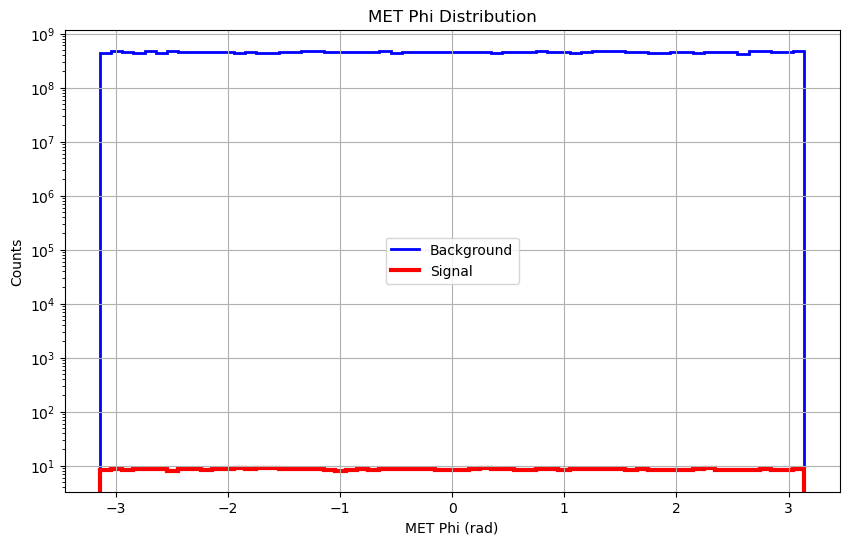

In [8]:
# Create histograms
met_phi_hist_background = Hist(
    axis.Regular(binning["Phi"]["bins"], *binning["Phi"]["range"], name="MET_Phi", label="MET Phi (rad)")
)
met_phi_hist_signal = Hist(
    axis.Regular(binning["Phi"]["bins"], *binning["Phi"]["range"], name="MET_Phi", label="MET Phi (rad)")
)


#Signal Data
signal_tree = signal_file[tree_name]
signal_met_phi = signal_tree["MissingET.Phi"].array(library="np")

numSigEvents = len(signal_met_phi)
signal_weight = calculateWeight(num_events=numSigEvents, effective_area= signal_crossSection, lumi = luminescence)

met_phi_hist_signal.fill(MET_Phi=signal_met_phi,weight = signal_weight)

#Background
for folder_name in os.listdir(current_dir):
    folder_path = os.path.join(current_dir, folder_name)
        
    # Check if the current item is a directory and if its name is in the background_folders dictionary
    if os.path.isdir(folder_path) and folder_name in background_folders:
        cross_section = background_folders[folder_name]
        
        for root_file in os.listdir(folder_path):
            if root_file.endswith(".root"):
                file_path = os.path.join(folder_path, root_file)
                background_file = uproot.open(file_path)
                background_tree = background_file[tree_name]

                background_met_phi = background_tree["MissingET.Phi"].array(library="np")
                numBkgEvents= len(background_met_phi)
                calculatedWeight = calculateWeight(num_events=numBkgEvents, effective_area= cross_section, lumi = luminescence)

                met_phi_hist_background.fill(MET_Phi=background_met_phi,weight =calculatedWeight)
                




#Set up histogram
plt.figure(figsize=(10, 6))

# Background histogram
plt.stairs(
    met_phi_hist_background.values(),
    met_phi_hist_background.axes[0].edges,
    color='blue',
    label='Background',
    linewidth=2
)

# Signal histogram
plt.stairs(
    met_phi_hist_signal.values(),
    met_phi_hist_signal.axes[0].edges,
    color='red',
    label='Signal',
    linewidth=3
)

# Add labels and legend
plt.xlabel('MET Phi (rad)')
plt.ylabel('Counts')
plt.yscale('log')
plt.title('MET Phi Distribution')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

<h2> Jets </h2>

First we make some functions for code reusability

In [9]:
DelphesSchema.error_missing_event_ids = False

def getJetsDataCoffea(dataname):
    """
    Returns signal_j0, signal_j1, signal_weight, background_j0_list, background_j1_list, background_weight_list.
    This version uses Coffea and Dask-Awkward for processing.
    """
    # Load signal events using Coffea
    events = NanoEventsFactory.from_root(
        signal_filepath,
        schemaclass=DelphesSchema,
        metadata={"dataset": "signal"}
    ).events()
    
    # Extract and filter jet data
    signal_jets_data = getattr(events.Jet, dataname.lower())
    
    # Ensure at least two jets are present in the event
    mask_signal = dak.num(signal_jets_data) >= 2
    signal_jets_filtered = signal_jets_data[mask_signal]
    
    # Extract j0 and j1
    signal_j0 = signal_jets_filtered[:, 0]
    signal_j1 = signal_jets_filtered[:, 1]

    # Calculate the number of signal events
    numSigEvents = dak.sum(mask_signal).compute()

    # Calculate signal weight
    signal_weight = calculateWeight(num_events=numSigEvents, effective_area=signal_crossSection, lumi=luminescence)

    # Background processing
    background_j0_list = []
    background_j1_list = []
    background_weight_list = []

    for folder_name in os.listdir(current_dir):
        folder_path = os.path.join(current_dir, folder_name)
        
        if os.path.isdir(folder_path) and folder_name in background_folders:
            cross_section = background_folders[folder_name]
            
            for root_file in os.listdir(folder_path):
                if root_file.endswith(".root"):
                    file_path = os.path.join(folder_path, root_file)
                    
                    # Load background events using Coffea
                    background_events = NanoEventsFactory.from_root(
                        file_path, 
                        schemaclass=DelphesSchema,
                        metadata={"dataset": folder_name}
                    ).events()
                    
                    # Extract and filter jet data
                    background_jets_data = getattr(background_events.Jet, dataname.lower())
                    
                    # Ensure at least two jets
                    mask_background = dak.num(background_jets_data) >= 2
                    background_jets_filtered = background_jets_data[mask_background]
                    
                    # Extract j0 and j1
                    background_j0 = background_jets_filtered[:, 0]
                    background_j1 = background_jets_filtered[:, 1]

                    # Calculate the number of background events
                    numBkgEvents = dak.sum(mask_background).compute()

                    # Calculate weight for each background file
                    calculatedWeight = calculateWeight(num_events=numBkgEvents, effective_area=cross_section, lumi=luminescence)

                    background_j0_list.append(background_j0)
                    background_j1_list.append(background_j1)
                    background_weight_list.append(calculatedWeight)

    return signal_j0, signal_j1, signal_weight, background_j0_list, background_j1_list, background_weight_list

In [10]:
def PlotJetsCoffea(binname, dataname):
    j0_hist_background = Hist(
        axis.Regular(binning[binname]["bins"], *binning[binname]["range"], name="thedata", label=dataname+"J0")
    )
    j0_hist_signal = Hist(
        axis.Regular(binning[binname]["bins"], *binning[binname]["range"], name="thedata", label=dataname+"J0")
    )

    # J1
    j1_hist_background = Hist(
        axis.Regular(binning[binname]["bins"], *binning[binname]["range"], name="thedata", label=dataname+"J1")
    )
    j1_hist_signal = Hist(
        axis.Regular(binning[binname]["bins"], *binning[binname]["range"], name="thedata", label=dataname+"J1")
    )

    j0sig, j1sig, sigweight, bkgj0list, bkgj1list, bkgweightlist = getJetsDataCoffea(dataname)

    # Convert dask_awkward arrays to numpy arrays
    j0sig = j0sig.compute()
    j1sig = j1sig.compute()
    sigweight = sigweight.compute() if hasattr(sigweight, 'compute') else sigweight

    # Fill histograms with converted data
    j0_hist_signal.fill(thedata=j0sig, weight=sigweight)
    j1_hist_signal.fill(thedata=j1sig, weight=sigweight)

    for i in range(len(bkgweightlist)):
        bkgj0list[i] = bkgj0list[i].compute()
        bkgj1list[i] = bkgj1list[i].compute()
        bkgweightlist[i] = bkgweightlist[i].compute() if hasattr(bkgweightlist[i], 'compute') else bkgweightlist[i]

        j0_hist_background.fill(thedata=bkgj0list[i], weight=bkgweightlist[i])
        j1_hist_background.fill(thedata=bkgj1list[i], weight=bkgweightlist[i])

    # Create a figure and a set of subplots (2 columns, 1 row)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot J0
    axs[0].stairs(
        j0_hist_background.values(),
        j0_hist_background.axes[0].edges,
        color='blue',
        label='Background',
        linewidth=2
    )
    axs[0].stairs(
        j0_hist_signal.values(),
        j0_hist_signal.axes[0].edges,
        color='red',
        label='Signal',
        linewidth=3
    )
    axs[0].set_xlabel(dataname+'(j0)')
    axs[0].set_ylabel('Counts')
    axs[0].set_yscale('log')
    axs[0].set_title(dataname+'(j0) Distributions')
    axs[0].legend()
    axs[0].grid(True)

    # Plot J1
    axs[1].stairs(
        j1_hist_background.values(),
        j1_hist_background.axes[0].edges,
        color='blue',
        label='Background',
        linewidth=2
    )
    axs[1].stairs(
        j1_hist_signal.values(),
        j1_hist_signal.axes[0].edges,
        color='red',
        label='Signal',
        linewidth=3
    )
    axs[1].set_xlabel(dataname+'(j1)')
    axs[1].set_ylabel('Counts')
    axs[1].set_yscale('log')
    axs[1].set_title(dataname+'(j1) Distributions')
    axs[1].legend()
    axs[1].grid(True)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

In [11]:
def getJetsData(dataname): #returns signalj0, signalj1, signalweight, backgroundj0list, backgroundj1list, backgroundweightlist
    # Signal processing
    signal_tree = signal_file[tree_name]
    signal_jets = signal_tree["Jet."+dataname].array(library="np")
    signal_filtered_jets = [entry for entry in signal_jets if len(entry) >= 2]  # At least two entries
    signal_j0 = np.array([entry[0] for entry in signal_filtered_jets])
    signal_j1 = np.array([entry[1] for entry in signal_filtered_jets])
 
    numSigEvents = len(signal_j0)
    signal_weight = calculateWeight(num_events=numSigEvents, effective_area= signal_crossSection, lumi = luminescence)

    # Background processing
    background_j0_list = []
    background_j1_list = []
    background_weight_list = []

    for folder_name in os.listdir(current_dir):
        folder_path = os.path.join(current_dir, folder_name)
        
        # Check if the current item is a directory and if its name is in the background_folders dictionary
        if os.path.isdir(folder_path) and folder_name in background_folders:
            cross_section = background_folders[folder_name]
            
            for root_file in os.listdir(folder_path):
                if root_file.endswith(".root"):
                    file_path = os.path.join(folder_path, root_file)
                    background_file = uproot.open(file_path)
                    background_tree = background_file[tree_name]
                    
                    # Extract and filter jet PT
                    background_jets = background_tree["Jet." + dataname].array(library="np")
                    background_filtered_jets = [entry for entry in background_jets if len(entry) >= 2]  # At least two entries
                    
                    # Extract J0 and J1
                    background_j0 = np.array([entry[0] for entry in background_filtered_jets])
                    background_j1 = np.array([entry[1] for entry in background_filtered_jets])

                    numBkgEvents = len(background_j0)
                    calculatedWeight = calculateWeight(num_events=numBkgEvents, effective_area= cross_section, lumi = luminescence)

                    background_j0_list.append(background_j0)
                    background_j1_list.append(background_j1)
                    background_weight_list.append(calculatedWeight)


    
    return signal_j0, signal_j1, signal_weight, background_j0_list, background_j1_list, background_weight_list
                    

In [12]:
def PlotJets(binname,dataname):
    j0_hist_background = Hist(
            axis.Regular(binning[binname]["bins"], *binning[binname]["range"], name="thedata", label=dataname+"J0")
        )
    j0_hist_signal = Hist(
        axis.Regular(binning[binname]["bins"], *binning[binname]["range"], name="thedata", label=dataname+"J0")
    )

    #J1
    j1_hist_background = Hist(
        axis.Regular(binning[binname]["bins"], *binning[binname]["range"], name="thedata", label=dataname+"J1")
    )
    j1_hist_signal = Hist(
        axis.Regular(binning[binname]["bins"], *binning[binname]["range"], name="thedata", label=dataname+"J1")
    )

    j0sig, j1sig, sigweight, bkgj0list, bkgj1list, bkgweightlist = getJetsData(dataname)

    j0_hist_signal.fill(thedata=j0sig, weight=sigweight)
    j1_hist_signal.fill(thedata=j1sig, weight=sigweight)


    for i in range(len(bkgweightlist)):
        j0_hist_background.fill(thedata=bkgj0list[i], weight=bkgweightlist[i])
        j1_hist_background.fill(thedata=bkgj1list[i], weight=bkgweightlist[i])
    

    # Create a figure and a set of subplots (2 columns, 1 row)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot J0
    axs[0].stairs(
        j0_hist_background.values(),
        j0_hist_background.axes[0].edges,
        color='blue',
        label='Background',
        linewidth=2
    )
    axs[0].stairs(
        j0_hist_signal.values(),
        j0_hist_signal.axes[0].edges,
        color='red',
        label='Signal',
        linewidth=3
    )
    axs[0].set_xlabel(dataname+'(j0)')
    axs[0].set_ylabel('Counts')
    axs[0].set_yscale('log')
    axs[0].set_title(dataname+'(j0) Distributions')
    axs[0].legend()
    axs[0].grid(True)

    # Plot J1
    axs[1].stairs(
        j1_hist_background.values(),
        j1_hist_background.axes[0].edges,
        color='blue',
        label='Background',
        linewidth=2
    )
    axs[1].stairs(
        j1_hist_signal.values(),
        j1_hist_signal.axes[0].edges,
        color='red',
        label='Signal',
        linewidth=3
    )
    axs[1].set_xlabel(dataname+'(j1)')
    axs[1].set_ylabel('Counts')
    axs[1].set_yscale('log')
    axs[1].set_title(dataname+'(j1) Distributions')
    axs[1].legend()
    axs[1].grid(True)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()


<h3> PT(j0) , PT(j1) </h3>

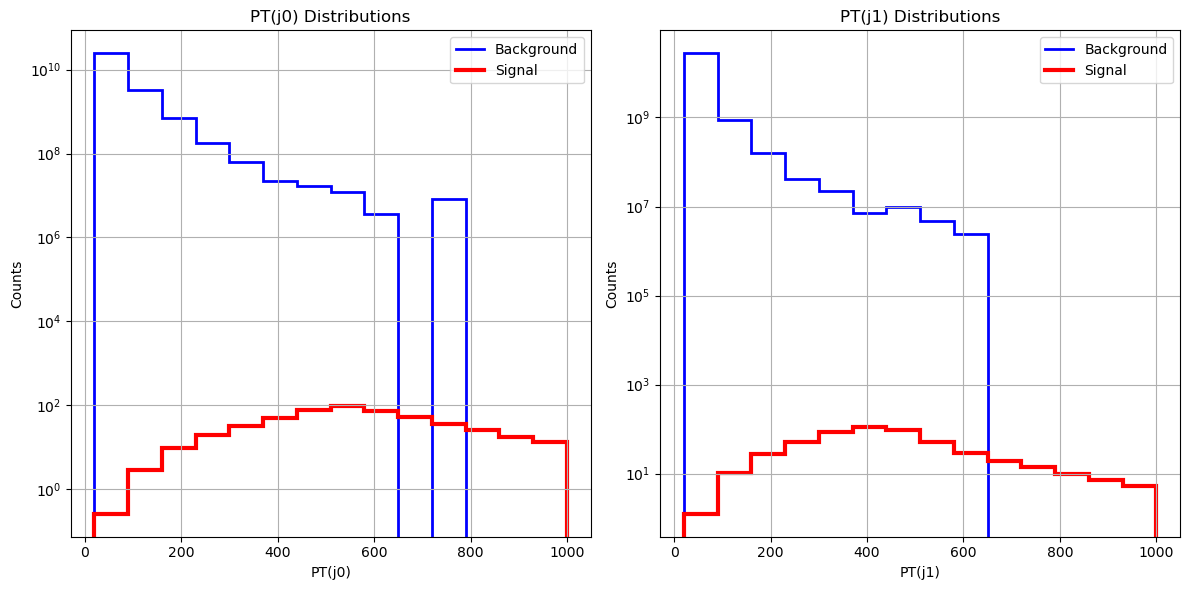

In [13]:
PlotJets("PT","PT")

<h3>Phi(J0,J1)</h3>

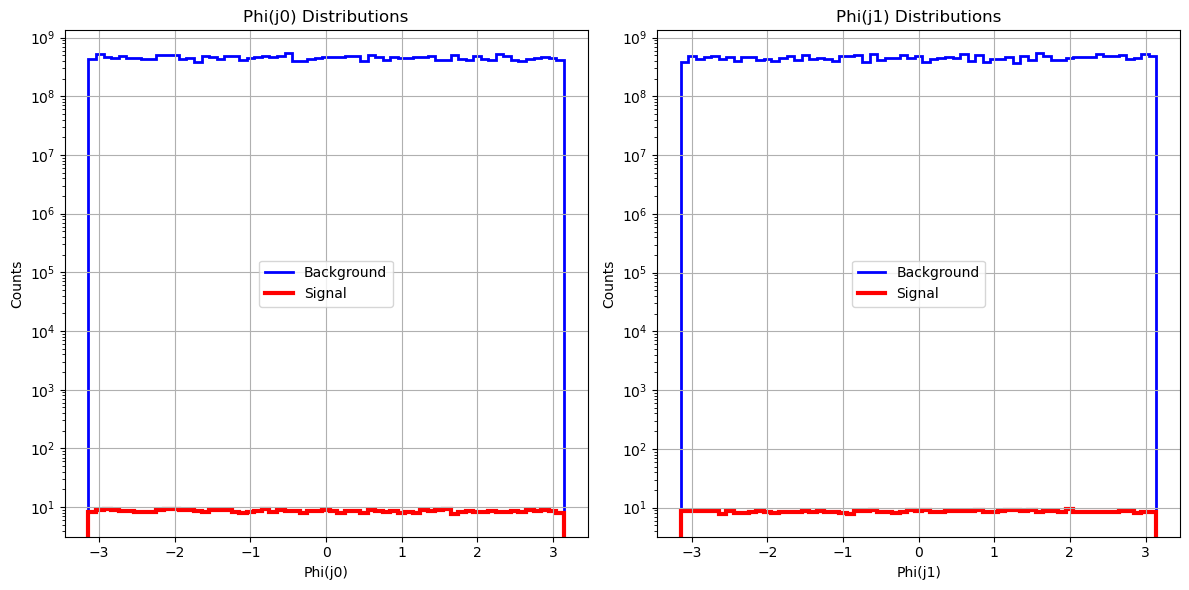

In [14]:
PlotJetsNew("Phi","Phi")

<h3> Eta (j0, j1) </h3>

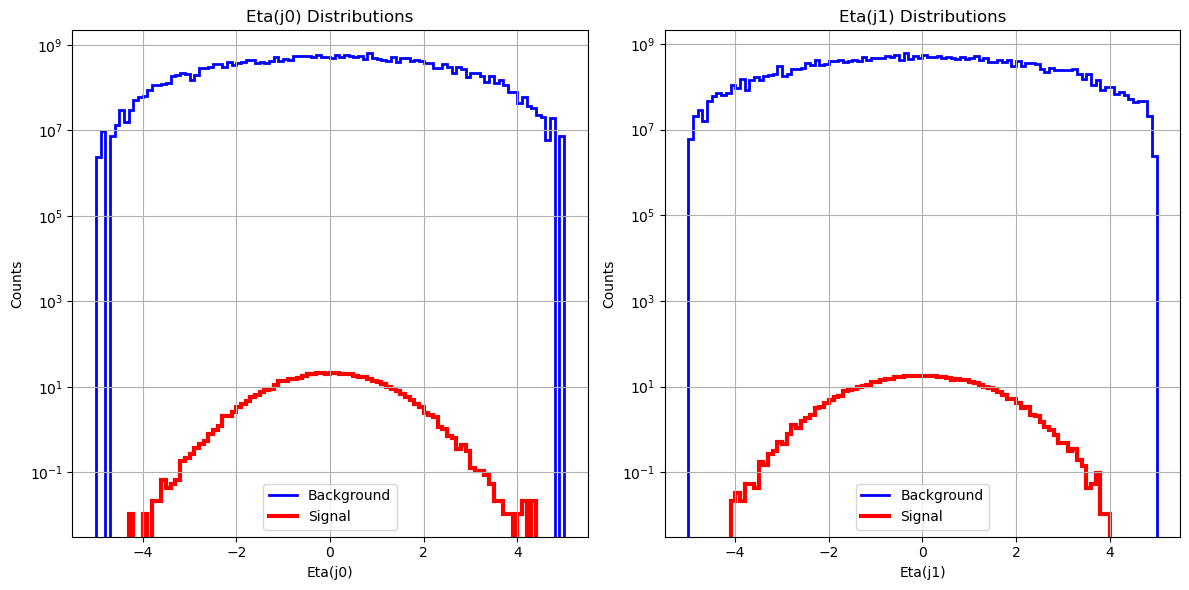

In [15]:
PlotJets("Eta","Eta")

<h3>Eta(j0) * Eta(j1)</h3>

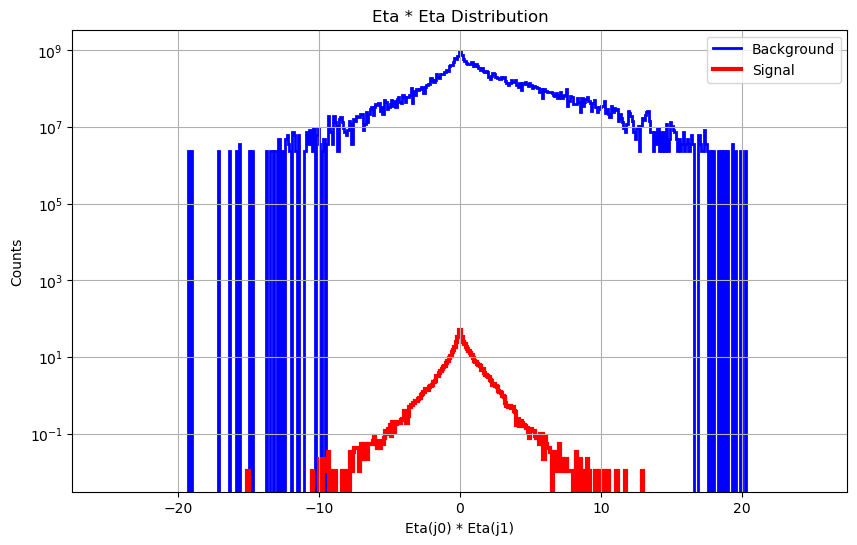

In [16]:
# Create histograms
etaeta_hist_background = Hist(
    axis.Regular(binning["Eta*Eta"]["bins"], *binning["Eta*Eta"]["range"], name="Eta*Eta", label="Eta*Eta")
)
etaeta_hist_signal = Hist(
    axis.Regular(binning["Eta*Eta"]["bins"], *binning["Eta*Eta"]["range"], name="Eta*Eta", label="Eta*Eta")
)


j0sig, j1sig, sigweight, bkgj0list, bkgj1list, bkgweightlist = getJetsData("Eta")

etaeta_hist_signal.fill(j0sig*j1sig, weight=sigweight)

for i in range(len(bkgweightlist)):
    etaeta_hist_background.fill(bkgj0list[i]*bkgj1list[i], weight = bkgweightlist[i])


#Set up histogram
plt.figure(figsize=(10, 6))

# Background histogram
plt.stairs(
    etaeta_hist_background.values(),
    etaeta_hist_background.axes[0].edges,
    color='blue',
    label='Background',
    linewidth=2
)

# Signal histogram
plt.stairs(
    etaeta_hist_signal.values(),
    etaeta_hist_signal.axes[0].edges,
    color='red',
    label='Signal',
    linewidth=3
)

# Add labels and legend
plt.xlabel('Eta(j0) * Eta(j1)')
plt.ylabel('Counts')
plt.yscale('log')
plt.title('Eta * Eta Distribution')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

    

<h3> Abs(Delta(J0,J1)) </h3>

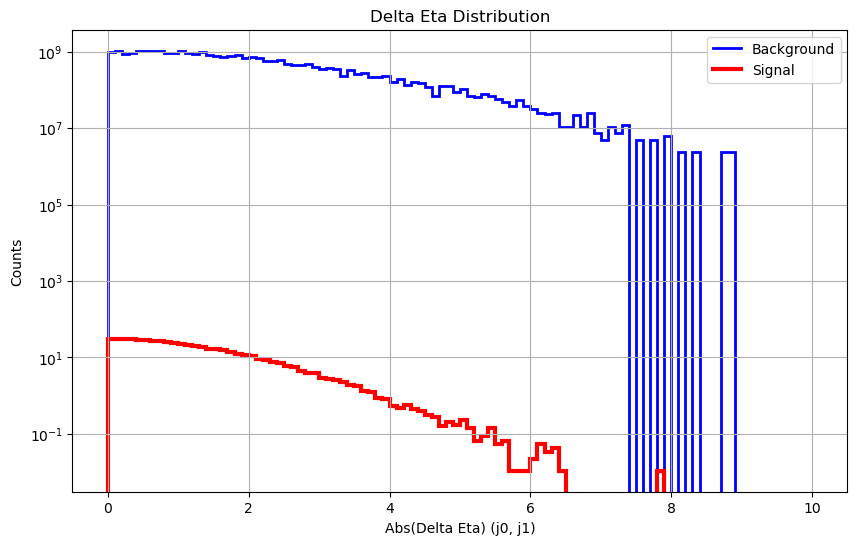

In [17]:
# Create histograms
deltaeta_hist_background = Hist(
     axis.Regular(binning["Delta_Eta"]["bins"], *binning["Delta_Eta"]["range"], name="DeltaEta", label="DeltaEta")
)

deltaeta_hist_signal = Hist(
    axis.Regular(binning["Delta_Eta"]["bins"], *binning["Delta_Eta"]["range"], name="DeltaEta", label="DeltaEta")
)


j0sig, j1sig, sigweight, bkgj0list, bkgj1list, bkgweightlist = getJetsData("Eta")

deltaeta_hist_signal.fill(np.abs(j0sig-j1sig), weight=sigweight)

for i in range(len(bkgweightlist)):
    deltaeta_hist_background.fill(np.abs(bkgj0list[i]-bkgj1list[i]), weight = bkgweightlist[i])


#Set up histogram
plt.figure(figsize=(10, 6))

# Background histogram
plt.stairs(
    deltaeta_hist_background.values(),
    deltaeta_hist_background.axes[0].edges,
    color='blue',
    label='Background',
    linewidth=2
)

# Signal histogram
plt.stairs(
    deltaeta_hist_signal.values(),
    deltaeta_hist_signal.axes[0].edges,
    color='red',
    label='Signal',
    linewidth=3
)

# Add labels and legend
plt.xlabel('Abs(Delta Eta) (j0, j1)')
plt.ylabel('Counts')
plt.yscale('log')
plt.title('Delta Eta Distribution')
plt.legend()
plt.grid(True)


# Show the plot
plt.show()

<h3> Invariant Mass (J0 J1) </h3>

In [18]:
def invariant_mass(pt0, eta0, phi0, m0, pt1, eta1, phi1, m1):
    # Energy and momentum components for Jet0
    pz0 = pt0 * np.sinh(eta0)
    e0 = np.sqrt(pt0**2 + pz0**2 + m0**2)
    px0 = pt0 * np.cos(phi0)
    py0 = pt0 * np.sin(phi0)

    # Energy and momentum components for Jet1
    pz1 = pt1 * np.sinh(eta1)
    e1 = np.sqrt(pt1**2 + pz1**2 + m1**2)
    px1 = pt1 * np.cos(phi1)
    py1 = pt1 * np.sin(phi1)

    # Invariant mass calculation
    e_total = e0 + e1
    px_total = px0 + px1
    py_total = py0 + py1
    pz_total = pz0 + pz1

    m2 = e_total**2 - (px_total**2 + py_total**2 + pz_total**2)
    m2 = np.maximum(m2, 0)  # This will replace negative values with 0
    return np.sqrt(m2)


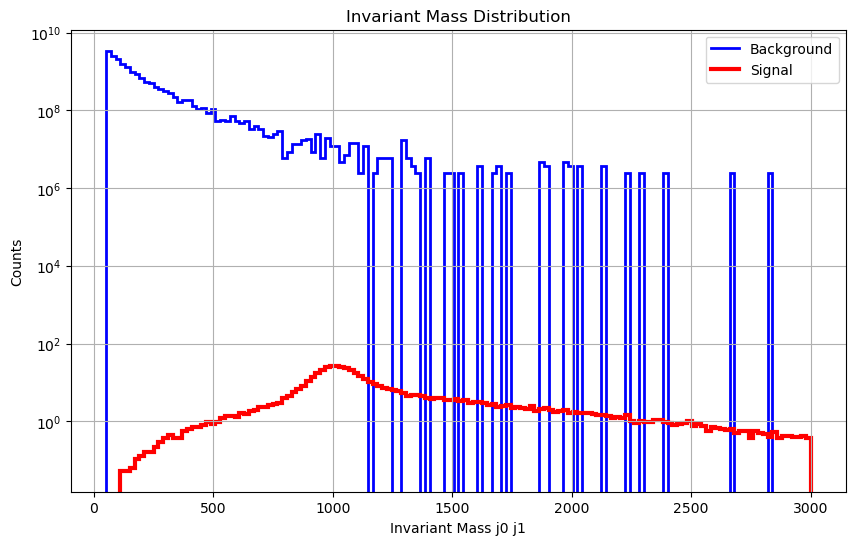

In [19]:
# Create histograms
invariant_hist_background = Hist(
     axis.Regular(binning["Invariant"]["bins"], *binning["Invariant"]["range"], name="Invariant", label="Invariant")
)

invariant_hist_signal = Hist(
    axis.Regular(binning["Invariant"]["bins"], *binning["Invariant"]["range"], name="Invariant", label="Invariant")
)

#Data needed: pt0, eta0, phi0, m0, pt1, eta1, phi1, m1

ptj0sig, ptj1sig, sigweight, ptbkgj0list, ptbkgj1list, bkgweightlist = getJetsData("PT")
etaj0sig, etaj1sig, sigweight, etabkgj0list, etabkgj1list, bkgweightlist = getJetsData("Eta")
phij0sig, phij1sig, sigweight, phibkgj0list, phibkgj1list, bkgweightlist = getJetsData("Phi")
massj0sig, massj1sig, sigweight, massbkgj0list, massbkgj1list, bkgweightlist  = getJetsData("Mass")

invariant_hist_signal.fill(
    invariant_mass(pt0=ptj0sig, eta0=etaj0sig, phi0 = phij0sig,m0=massj0sig,
                   pt1=ptj1sig, eta1=etaj1sig, phi1 = phij1sig,m1=massj1sig),
    weight = sigweight)

for i in range(len(bkgweightlist)):
    invariant_hist_background.fill(
    invariant_mass(pt0=ptbkgj0list[i], eta0=etabkgj0list[i], phi0 = phibkgj1list[i],m0=massbkgj0list[i],
                   pt1=ptbkgj1list[i], eta1=etabkgj1list[i], phi1 = phibkgj1list[i],m1=massbkgj1list[i]),
            weight = bkgweightlist[i])


#Set up histogram
plt.figure(figsize=(10, 6))

# Background histogram
plt.stairs(
    invariant_hist_background.values(),
    invariant_hist_background.axes[0].edges,
    color='blue',
    label='Background',
    linewidth=2
)

# Signal histogram
plt.stairs(
    invariant_hist_signal.values(),
    invariant_hist_signal.axes[0].edges,
    color='red',
    label='Signal',
    linewidth=3
)

# Add labels and legend
plt.xlabel('Invariant Mass j0 j1')
plt.ylabel('Counts')
plt.yscale('log')
plt.title('Invariant Mass Distribution')
plt.legend()
plt.grid(True)


# Show the plot
plt.show()

<h1> Now we start findsing Significance, making Cuts <h1>

First we will be using $\eta$($j_0$) *  $\eta$($j_1$) to make this cut. 

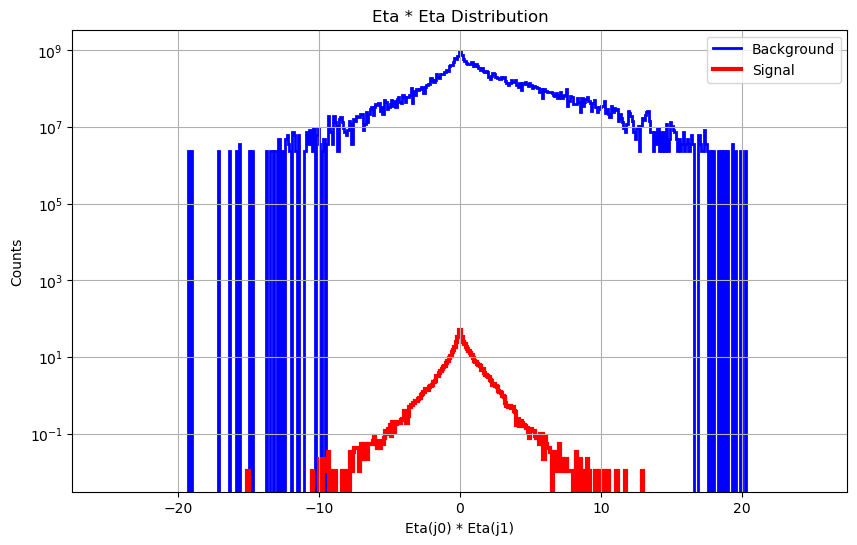

In [20]:
# Create histograms
etaeta_hist_background = Hist(
    axis.Regular(binning["Eta*Eta"]["bins"], *binning["Eta*Eta"]["range"], name="Eta*Eta", label="Eta*Eta")
)
etaeta_hist_signal = Hist(
    axis.Regular(binning["Eta*Eta"]["bins"], *binning["Eta*Eta"]["range"], name="Eta*Eta", label="Eta*Eta")
)


j0sig, j1sig, sigweight, bkgj0list, bkgj1list, bkgweightlist  = getJetsData("Eta")

etaeta_hist_signal.fill(j0sig*j1sig, weight=sigweight)

for i in range(len(bkgweightlist)):
    etaeta_hist_background.fill(bkgj0list[i]*bkgj1list[i], weight = bkgweightlist[i])


#Set up histogram
plt.figure(figsize=(10, 6))

# Background histogram
plt.stairs(
    etaeta_hist_background.values(),
    etaeta_hist_background.axes[0].edges,
    color='blue',
    label='Background',
    linewidth=2
)

# Signal histogram
plt.stairs(
    etaeta_hist_signal.values(),
    etaeta_hist_signal.axes[0].edges,
    color='red',
    label='Signal',
    linewidth=3
)

# Add labels and legend
plt.xlabel('Eta(j0) * Eta(j1)')
plt.ylabel('Counts')
plt.yscale('log')
plt.title('Eta * Eta Distribution')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

<h4> Significance Plot </h4>

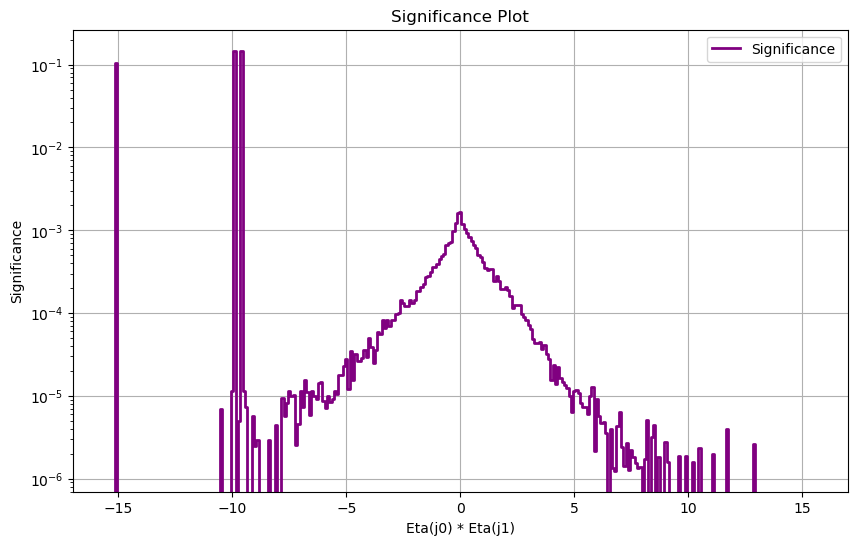

Top 5 Significance Values and Their Corresponding Bins:
Rank 1: Significance = 0.147, Bin = -9.600
Rank 2: Significance = 0.147, Bin = -9.900
Rank 3: Significance = 0.104, Bin = -15.100
Rank 4: Significance = 0.002, Bin = 0.000
Rank 5: Significance = 0.002, Bin = -0.100


In [21]:
signal_counts = etaeta_hist_signal.values()
bkg_counts = etaeta_hist_background.values()

significance = []
for n_s, n_b in zip(signal_counts, bkg_counts):
    if n_b + n_s > 0:
        S = calculateSignificance(numSig=n_s, numBkg=n_b)
        significance.append(S)
    else:
        significance.append(0)  # If both are zero, significance is zero.

significance = np.array(significance)


# Get bin edges from the histogram
bin_edges = etaeta_hist_signal.axes[0].edges

# Plot significance
plt.figure(figsize=(10, 6))
plt.step(bin_edges[:-1], significance, where='mid', label='Significance', color='purple', linewidth=2)

# Add labels and title
plt.xlabel('Eta(j0) * Eta(j1)')
plt.xlim(-17, 17)  #from visual inspection
plt.ylabel('Significance')
plt.yscale('log')
plt.title('Significance Plot')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()



#Top 5 points
# Find the indices of the top 5 significance values
top_indices = np.argsort(significance)[-5:]  # Get indices of the 5 largest values

# Reverse to get them in descending order
top_indices = top_indices[::-1]

# Retrieve the top 5 significance values and their corresponding bin edges
top_significance_values = significance[top_indices]
top_bin_edges = bin_edges[top_indices]

# Print the top 5 significance values and their corresponding bins
print("Top 5 Significance Values and Their Corresponding Bins:")
for i, idx in enumerate(top_indices):
    print(f"Rank {i + 1}: Significance = {top_significance_values[i]:.3f}, Bin = {top_bin_edges[i]:.3f}")


We chose cut to be eta(j0)*eta(j1) >= 

We will now plot invariant mass, with said cut applied

<h4> Now we will plot Delta(Eta(j0,j1)), with our cut, and use this new data to make our next cut </h4>

<b> $\eta$($j_0$) *  $\eta$($j_1$) </b>

<b> abs($\Delta$($j_0$,$j_1$)) </b>

<b>Pt($j_0$) </b>

<b>Pt($j_1$)</b>

<b> $M_{ET}$, <b>

<h1>Step 5: Compile full Cut Chart </h1>

In [ ]:

column_width = 12  

# Create the grid header
header_row = f"{'Cut #':^{column_width}} | {'SM Events':^{column_width}} | {'NP Events':^{column_width}} | {'Significance':^{column_width}}"
print(header_row)

# Print a separator line
print("-" * (len(header_row) + 1))

#Initial Conditions
init_data = f"{'    Init':{column_width}} | {SM_events[0]:^{column_width}} | {NP_events[0]:^{column_width}} | {Significance[0]:^{column_width}.2f}"  # 
print(init_data)

# Iterate through data and format each row
for i in range(1, num_cuts):  # Use range(1, num_cuts+1) for 1 to num_cuts (inclusive)
    row_data = f"{i:{column_width}} | {SM_events[i]:^{column_width}} | {NP_events[i]:^{column_width}} | {Significance[i]:^{column_width}.2f}" 
    print(row_data)




<h2> CODE TESTING </h2>

In [23]:
def applySingleCut(df, mask_function):
    mask = mask_function(df)
    return df[mask]



def applyMultipleCuts(df, mask_functions):
    
    for mask in mask_functions:
        df = applySingleCut(df, mask)

    return df

In [24]:
def mask_pt_j0_greater_than_30(df):
    # Extract PT for j0
    pt_j0 = df["Jet.PT"].apply(lambda x: x[0] if len(x) > 0 else None)
    
    # Create mask where PT(j0) > 30
    return pt_j0 > 550


def mask_eta_condition(df):
    # Extract Eta for j0 and j1
    eta_j0 = df["Jet.Eta"].apply(lambda x: x[0] if len(x) > 0 else None)
    eta_j1 = df["Jet.Eta"].apply(lambda x: x[1] if len(x) > 1 else None)

    # Create mask where Eta(j0) * Eta(j1) >= 0
    return (eta_j0 * eta_j1) >= 0

In [25]:
fullTree = openTree(signal_filepath)


maskList = [mask_eta_condition, mask_pt_j0_greater_than_30]


ptover30 = applyMultipleCuts(fullTree,maskList)

print(ptover30['Jet.PT'])



0        [612.2195434570312, 350.4515686035156, 83.5366...
2        [829.366943359375, 768.7811889648438, 541.0628...
3        [841.2637329101562, 821.0570068359375, 598.777...
10       [658.546875, 523.6924438476562, 134.6850585937...
13       [564.7594604492188, 474.1815185546875, 149.301...
                               ...                        
49986    [602.9717407226562, 386.547607421875, 138.7643...
49991    [991.771240234375, 975.6318359375, 574.3625488...
49997    [1034.6842041015625, 815.1199340820312, 621.60...
49998    [712.75048828125, 413.6299743652344, 299.86630...
49999    [555.7859497070312, 524.789306640625, 125.3558...
Name: Jet.PT, Length: 16002, dtype: awkward


In [26]:
def getJetsDataNewCuts(dataname, masklist): 
    #used when we are working with J0,J1 stuff (which is alot)
    
    #Get Signal Data
    df = openTree(signal_filepath)

    if(maskList is not None):
        df = applyMultipleCuts(df, maskList)
    
    # Extract signal jet data
    signal_jets = df["Jet." + dataname].values
    signal_filtered_jets = [entry for entry in signal_jets if len(entry) >= 2]  # At least two entries
    signal_j0 = np.array([entry[0] for entry in signal_filtered_jets])
    signal_j1 = np.array([entry[1] for entry in signal_filtered_jets])

    numSigEvents = len(signal_j0)
    signal_weight = calculateWeight(num_events=numSigEvents, effective_area=signal_crossSection, lumi=luminescence)

    # Background processing
    background_j0_list = []
    background_j1_list = []
    background_weight_list = []

    for folder_name in os.listdir(current_dir):
        folder_path = os.path.join(current_dir, folder_name)

        # Check if the current item is a directory and if its name is in the background_folders dictionary
        if os.path.isdir(folder_path) and folder_name in background_folders:
            cross_section = background_folders[folder_name]

            for root_file in os.listdir(folder_path):
                if root_file.endswith(".root"):
                    file_path = os.path.join(folder_path, root_file)
                    background_df = openTree(file_path)  # Use openTree to get the DataFrame

                    if(maskList is not None):
                        background_df = applyMultipleCuts(background_df, maskList)

                    # Extract and filter jet data
                    background_jets = background_df["Jet." + dataname].values
                    background_filtered_jets = [entry for entry in background_jets if len(entry) >= 2]  # At least two entries

                    # Extract J0 and J1
                    background_j0 = np.array([entry[0] for entry in background_filtered_jets])
                    background_j1 = np.array([entry[1] for entry in background_filtered_jets])

                    numBkgEvents = len(background_j0)
                    calculatedWeight = calculateWeight(num_events=numBkgEvents, effective_area=cross_section, lumi=luminescence)

                    background_j0_list.append(background_j0)
                    background_j1_list.append(background_j1)
                    background_weight_list.append(calculatedWeight)

    return signal_j0, signal_j1, signal_weight, background_j0_list, background_j1_list, background_weight_list

In [28]:
def PlotJetsNew(binname,dataname,masklist):
    j0_hist_background = Hist(
            axis.Regular(binning[binname]["bins"], *binning[binname]["range"], name="thedata", label=dataname+"J0")
        )
    j0_hist_signal = Hist(
        axis.Regular(binning[binname]["bins"], *binning[binname]["range"], name="thedata", label=dataname+"J0")
    )

    #J1
    j1_hist_background = Hist(
        axis.Regular(binning[binname]["bins"], *binning[binname]["range"], name="thedata", label=dataname+"J1")
    )
    j1_hist_signal = Hist(
        axis.Regular(binning[binname]["bins"], *binning[binname]["range"], name="thedata", label=dataname+"J1")
    )

    j0sig, j1sig, sigweight, bkgj0list, bkgj1list, bkgweightlist = getJetsDataNewCuts(dataname,masklist)

    j0_hist_signal.fill(thedata=j0sig, weight=sigweight)
    j1_hist_signal.fill(thedata=j1sig, weight=sigweight)


    for i in range(len(bkgweightlist)):
        j0_hist_background.fill(thedata=bkgj0list[i], weight=bkgweightlist[i])
        j1_hist_background.fill(thedata=bkgj1list[i], weight=bkgweightlist[i])
    

    # Create a figure and a set of subplots (2 columns, 1 row)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot J0
    axs[0].stairs(
        j0_hist_background.values(),
        j0_hist_background.axes[0].edges,
        color='blue',
        label='Background',
        linewidth=2
    )
    axs[0].stairs(
        j0_hist_signal.values(),
        j0_hist_signal.axes[0].edges,
        color='red',
        label='Signal',
        linewidth=3
    )
    axs[0].set_xlabel(dataname+'(j0)')
    axs[0].set_ylabel('Counts')
    axs[0].set_yscale('log')
    axs[0].set_title(dataname+'(j0) Distributions')
    axs[0].legend()
    axs[0].grid(True)

    # Plot J1
    axs[1].stairs(
        j1_hist_background.values(),
        j1_hist_background.axes[0].edges,
        color='blue',
        label='Background',
        linewidth=2
    )
    axs[1].stairs(
        j1_hist_signal.values(),
        j1_hist_signal.axes[0].edges,
        color='red',
        label='Signal',
        linewidth=3
    )
    axs[1].set_xlabel(dataname+'(j1)')
    axs[1].set_ylabel('Counts')
    axs[1].set_yscale('log')
    axs[1].set_title(dataname+'(j1) Distributions')
    axs[1].legend()
    axs[1].grid(True)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

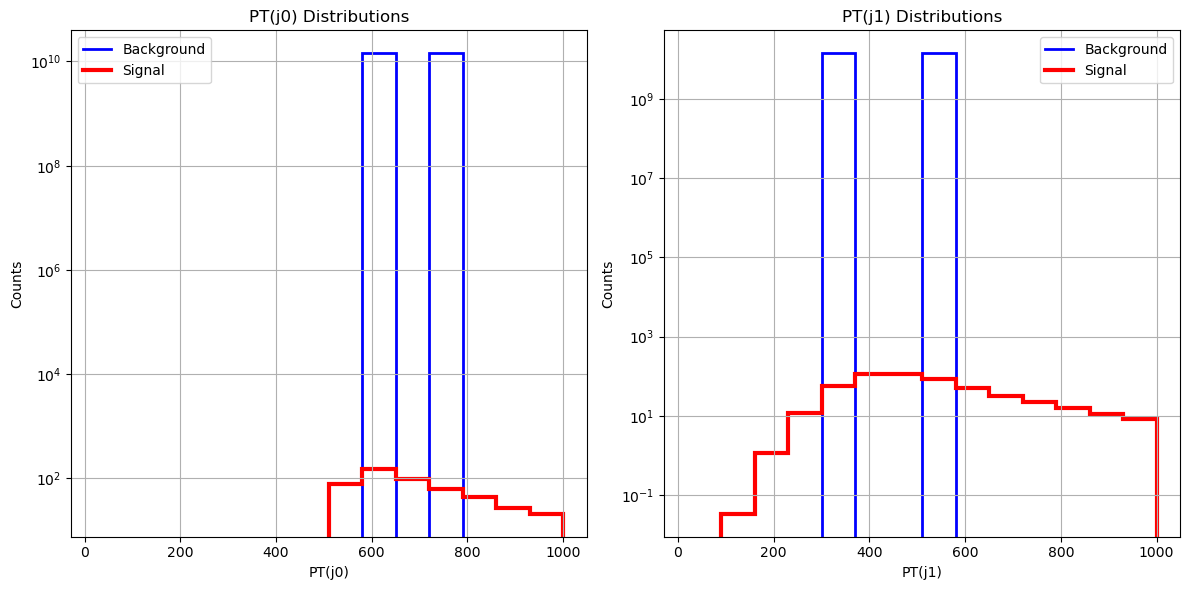

In [29]:
PlotJetsNew("PT","PT",maskList)